<a href="https://colab.research.google.com/github/mahim83/Building-a-Generative-Adversarial-network/blob/main/Build_a_Generative_Adversarial_Network_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning with PyTorch : Build a Generative Adversarial Network

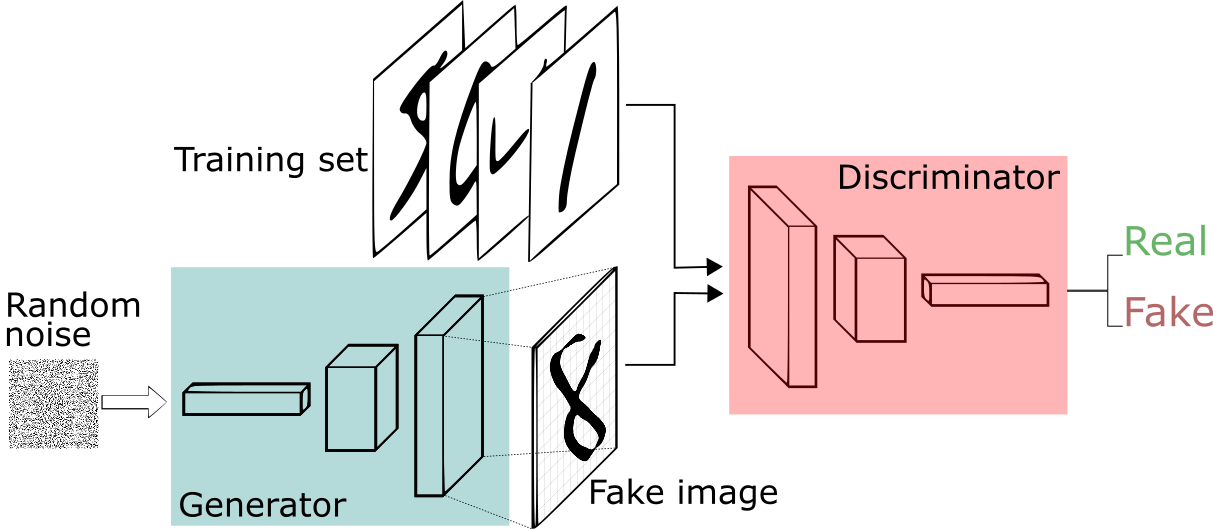

In [ ]:
import torch
torch.manual_seed(42)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Configurations

In [ ]:
device = 'cuda' # image = image.to(device)

batch_size = 128 # trainloader , training loop

noise_dim = 64  # generator model

# optimizers parameters

lr = 0.002
beta_1 = 0.5
beta_2 = 0.99

# Traning variables

epochs = 20

# Load MNIST Dataset

In [ ]:
from torchvision import datasets, transforms as T

In [ ]:
train_augs  = T.Compose([
    T.RandomRotation((-20,+20)),
    T.ToTensor(), # (h,w,c) -> (c,h,w)
])

In [ ]:
trainset = datasets.MNIST('MNIST/', train=True, download=True, transform=train_augs)

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 464kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


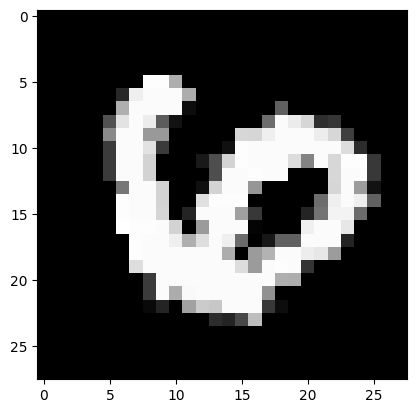

In [ ]:
image , label = trainset[9000]

plt.imshow(image.squeeze(), cmap='gray')

In [ ]:
print("total images present in trainset are :",len(trainset))

total images present in trainset are : 60000


# Load Dataset Into Batches

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [ ]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [ ]:
print("total number of batches in trainloader :",len(trainloader))

total number of batches in trainloader : 469


In [ ]:
dataiter = iter(trainloader)
images, _ = next(dataiter)
print(images.shape)

torch.Size([128, 1, 28, 28])


In [ ]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

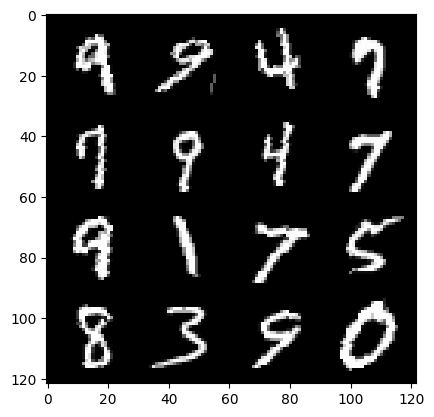

In [ ]:
show_tensor_images(images , num_images=16)

# Create Discriminator Network

In [ ]:
#In case if torch summary is not installed

!pip install torchsummary

In [ ]:
from torch import nn
from torchsummary import summary

In [ ]:
'''

Network : Discriminator

input : (bs, 1, 28, 28)
      |                                                                                               ---- SUMMARY ----
      V
Conv2d( in_channels = 1, out_channels = 16, kernel_size = (3,3), stride = 2)                           #(bs, 16, 13, 13)
BatchNorm2d()                                                                                          #(bs, 16, 13, 13)
LeakyReLU()                                                                                            #(bs, 16, 13, 13)
      |
      V
Conv2d( in_channels = 16, out_channels = 32, kernel_size = (5,5), stride = 2)                          #(bs, 32, 5, 5)
BatchNorm2d()                                                                                          #(bs, 32, 5, 5)
LeakyReLU()                                                                                            #(bs, 32, 5, 5)
      |
      V
Conv2d( in_channels = 32, out_channels = 64, kernel_size = (5,5), stride = 2)                          #(bs, 64, 1, 1)
BatchNorm2d()                                                                                          #(bs, 64, 1, 1)
LeakyReLU()                                                                                            #(bs, 64, 1, 1)
      |
      V
Flatten()                                                                                              #(bs, 64)
Linear(in_features = 64, out_features = 1)                                                             #(bs, 1)

'''

In [ ]:
def get_disc_block(in_channels,out_channels,kernel_size,stride):
  return nn.Sequential(
      nn.Conv2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.block_1 = get_disc_block(1,16,(3,3),2)
    self.block_2 = get_disc_block(16,32,(5,5),2)
    self.block_3 = get_disc_block(32,64,(5,5),2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features=64,out_features=1)

  def forward(self,images):

    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)

    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [ ]:
D = Discriminator()
D.to(device)

summary(D,input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

# Create Generator Network

In [ ]:
'''

Network : Generator

z_dim = 64
input : (bs,z_dim)

      |
      | Reshape
      V

input : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)
      |                                                                                               ---- SUMMARY ----
      V
ConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)
BatchNorm2d()                                                                                          #(bs, 256, 3, 3)
ReLU()                                                                                                 #(bs, 256, 3, 3)
      |
      V
ConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)
BatchNorm2d()                                                                                          #(bs, 128, 6, 6)
ReLU()                                                                                                 #(bs, 128, 6, 6)
      |
      V
ConvTranspose2d( in_channels = 128, out_channels = 64, kernel_size = (3,3), stride = 2)                #(bs, 64, 13, 13)
BatchNorm2d()                                                                                          #(bs, 64, 13, 13)
ReLU()                                                                                                 #(bs, 64, 13, 13)
      |
      V
ConvTranspose2d( in_channels = 64, out_channels = 1, kernel_size = (4,4), stride = 2)                  #(bs, 1, 28, 28)
Tanh()                                                                                                 #(bs, 1, 28, 28)

'''

'\n\nNetwork : Generator\n\nz_dim = 64\ninput : (bs,z_dim)\n\n      |\n      | Reshape\n      V\n\ninput : (bs, channel, height, width) -> (bs, z_dim , 1 , 1)\n      |                                                                                               ---- SUMMARY ----\n      V\nConvTranspose2d( in_channels = z_dim, out_channels = 256, kernel_size = (3,3), stride = 2)             #(bs, 256, 3, 3)\nBatchNorm2d()                                                                                          #(bs, 256, 3, 3)\nReLU()                                                                                                 #(bs, 256, 3, 3)\n      |\n      V\nConvTranspose2d( in_channels = 256, out_channels = 128, kernel_size = (4,4), stride = 1)               #(bs, 128, 6, 6)\nBatchNorm2d()                                                                                          #(bs, 128, 6, 6)\nReLU()                                                                                 

In [ ]:
def get_gen_block(in_channels,out_channels,kernel_size,stride ,final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
        nn.Tanh()
    )
  return nn.Sequential(
      nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [ ]:
class Generator(nn.Module):
  def __init__(self,z_dim):
    super(Generator,self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim,256,(3,3),2)
    self.block_2 = get_gen_block(256,128,(4,4),1)
    self.block_3 = get_gen_block(128,64,(3,3),2)

    self.block_4 = get_gen_block(64,1,(4,4),2,final_block=True)

  def forward(self,r_noise_vec):

    #(bs , noise_dim) -> (bs,noise_dim ,1,1)
    x = r_noise_vec.view(-1,self.noise_dim,1,1)

    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [ ]:
G = Generator(noise_dim)
G.to(device)

summary(G,input_size = (1,noise_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [ ]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [ ]:
D.apply(weights_init)
G.apply(weights_init)

Generator(
  (block_1): Sequential(
    (0): ConvTranspose2d(64, 256, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_2): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_3): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block_4): Sequential(
    (0): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2))
    (1): Tanh()
  )
)

# Create Loss Function and Load Optimizer

In [ ]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred,ground_truth)
  return loss



In [ ]:
D_opt = torch.optim.Adam(D.parameters(),lr=lr,betas=(beta_1,beta_2))
G_opt = torch.optim.Adam(G.parameters(),lr=lr,betas=(beta_1,beta_2))

# Training Loop

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 1 | D_loss : 0.6772796116403933 | G_loss : 0.7288478198590309


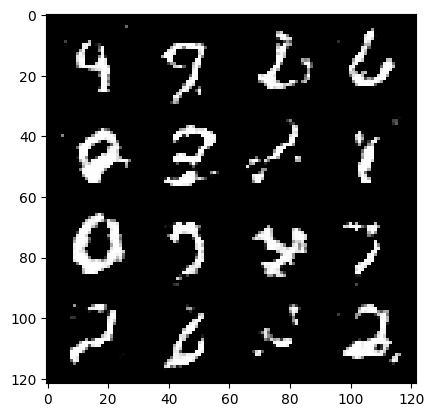

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 2 | D_loss : 0.6554082046185475 | G_loss : 0.7911972310751486


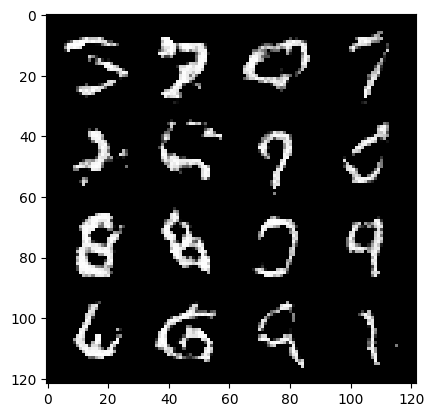

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 3 | D_loss : 0.6552401648909807 | G_loss : 0.8037764710912318


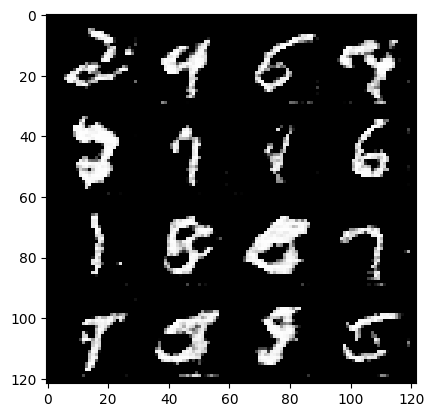

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 4 | D_loss : 0.6512780307706739 | G_loss : 0.8207166779524228


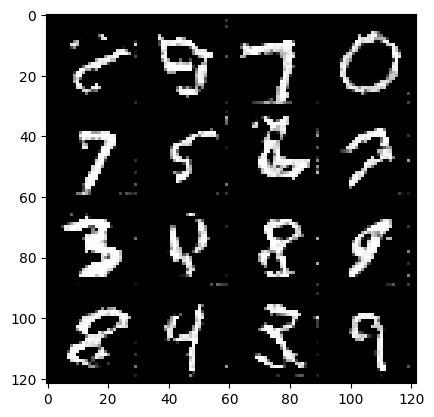

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 5 | D_loss : 0.6500973332919546 | G_loss : 0.8273582539832922


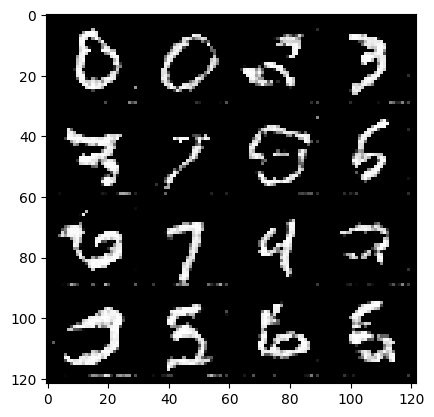

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 6 | D_loss : 0.6515649491027474 | G_loss : 0.8325497219557447


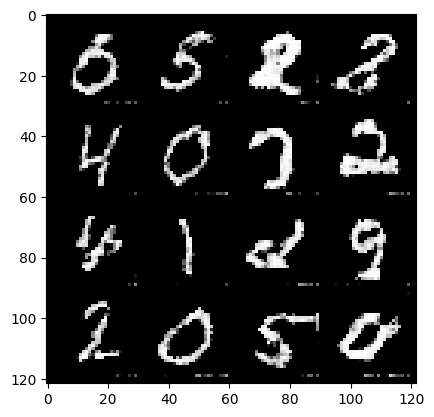

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 7 | D_loss : 0.6461569122922446 | G_loss : 0.8410371852073588


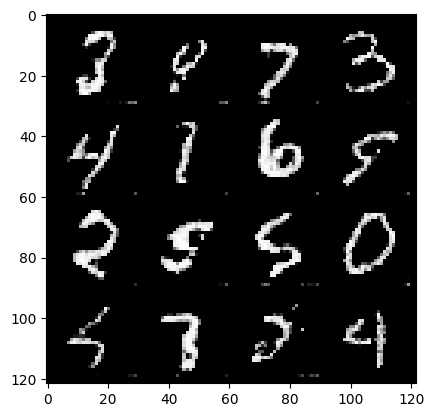

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 8 | D_loss : 0.6333482317578818 | G_loss : 0.8730572636193558


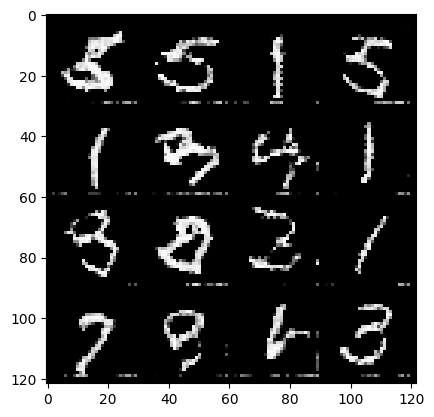

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 9 | D_loss : 0.6162683968859186 | G_loss : 0.9251458433899544


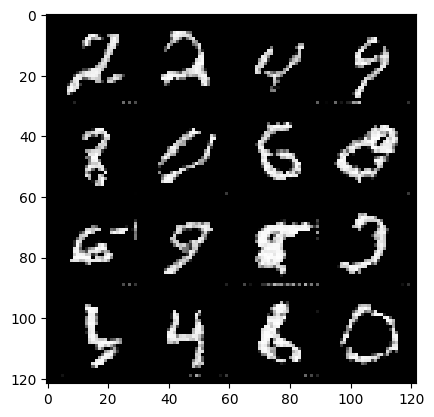

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 10 | D_loss : 0.5996888089281663 | G_loss : 0.9704929989284036


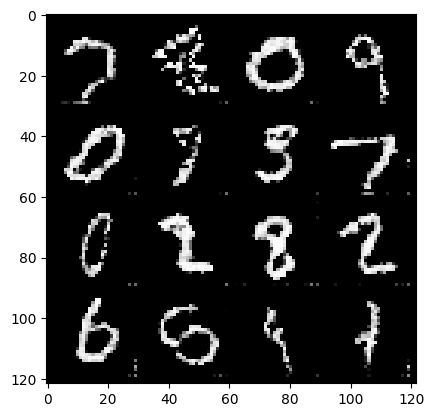

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 11 | D_loss : 0.5795777347296286 | G_loss : 1.0368133117395169


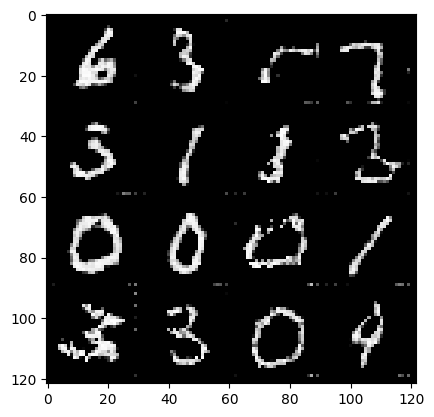

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 12 | D_loss : 0.5673560699674366 | G_loss : 1.0983931253205483


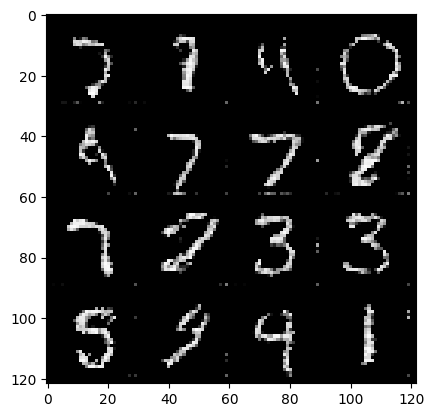

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 13 | D_loss : 0.5541636017975269 | G_loss : 1.1181663603924994


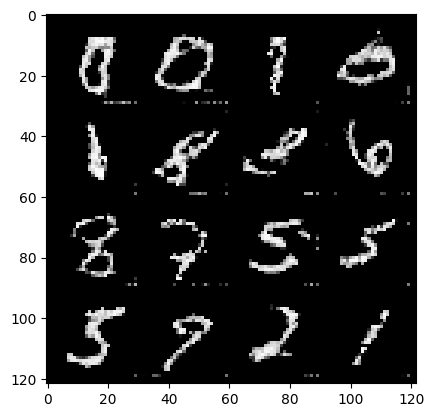

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 14 | D_loss : 0.5528347780709582 | G_loss : 1.1417581132734254


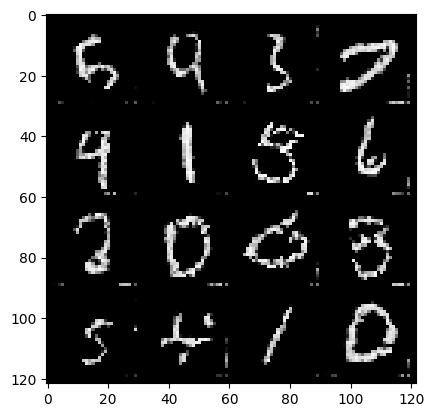

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 15 | D_loss : 0.547856420087916 | G_loss : 1.1646758729715083


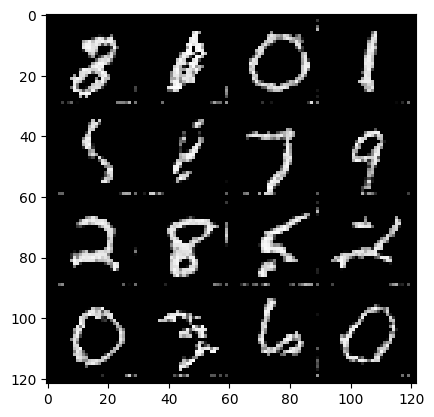

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 16 | D_loss : 0.5418758677012885 | G_loss : 1.1756115093160031


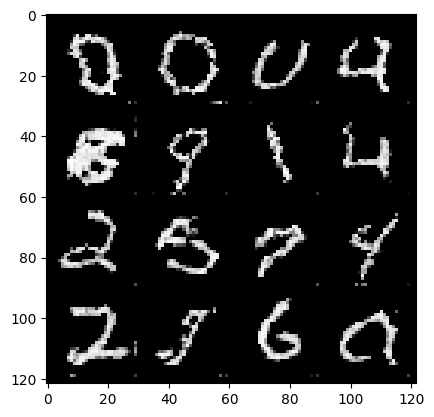

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 17 | D_loss : 0.539114977441617 | G_loss : 1.203586148300659


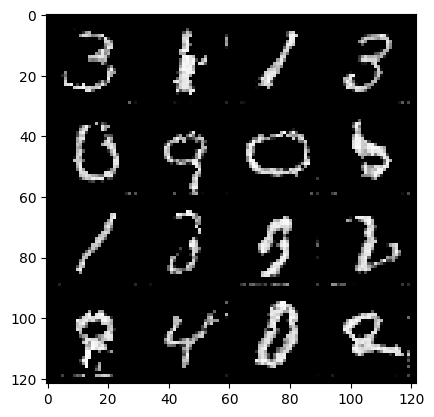

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 18 | D_loss : 0.5337142155749965 | G_loss : 1.218136657275625


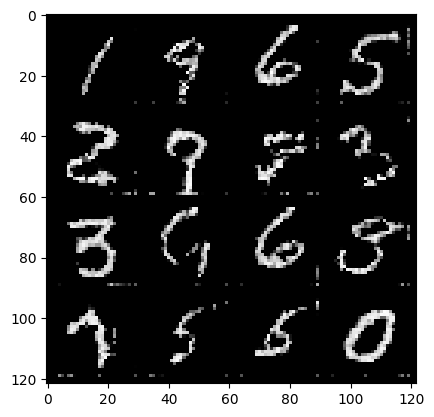

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 19 | D_loss : 0.531026514989735 | G_loss : 1.231767180123563


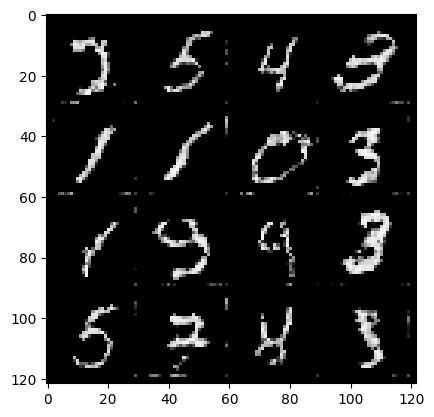

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch : 20 | D_loss : 0.5252007885909538 | G_loss : 1.2473737863081096


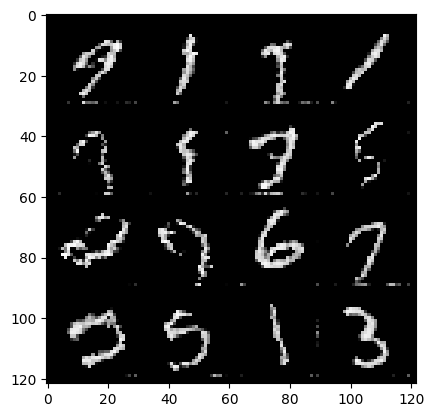

In [ ]:
for epoch in range(epochs):

  total_d_loss = 0.0
  total_g_loss = 0.0
  for real_img,_ in tqdm(trainloader):

    real_images = real_img.to(device)

    # Train Discriminator
    D_opt.zero_grad()

    # Pass real images through discriminator
    D_pred_real = D(real_images)
    D_real_loss = real_loss(D_pred_real)

    # Generate fake images and pass through discriminator
    noise_for_D = torch.randn(batch_size, noise_dim, device=device)
    fake_img_for_D = G(noise_for_D).detach() # Detach to prevent gradients flowing to G
    D_pred_fake = D(fake_img_for_D)
    D_fake_loss = fake_loss(D_pred_fake)

    D_loss = (D_real_loss + D_fake_loss) / 2

    total_d_loss += D_loss.item()
    D_loss.backward()
    D_opt.step()

    # Train Generator
    G_opt.zero_grad()

    # Generate new fake images and pass through discriminator (do not detach)
    noise_for_G = torch.randn(batch_size, noise_dim, device=device)
    fake_img_for_G = G(noise_for_G)
    D_pred_for_G = D(fake_img_for_G)

    # Generator wants discriminator to think fakes are real
    G_loss = real_loss(D_pred_for_G)

    total_g_loss += G_loss.item()
    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss/len(trainloader)
  avg_g_loss = total_g_loss/len(trainloader)

  print("Epoch : {} | D_loss : {} | G_loss : {}".format(epoch + 1, avg_d_loss, avg_g_loss))

  show_tensor_images(fake_img_for_G)


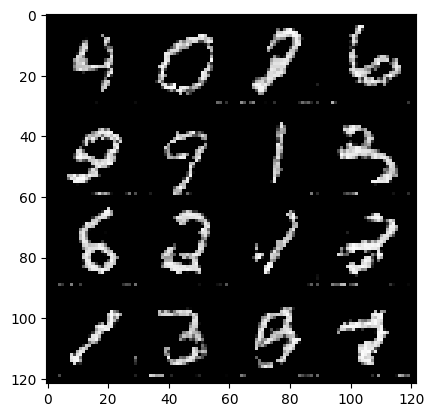

In [ ]:
# Run after training is completed.
# Now you can use Generator Network to generate handwritten images

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

show_tensor_images(generated_image)